# Prerequisites

Make sure you have downloaded the following pakcages in your environment:

- nltk: nltk.download('stopwords')
- xmltodict
- numpy
- gensim
- pandas
- matplotlib
- dask
- sklearn

# Imports

Import the required libraries for this project.

In [1]:
import json
import xmltodict as xtd
import numpy as np
import os
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import PorterStemmer
from joblib import Parallel, delayed
from gensim import corpora
from gensim import models
import pandas as pd
from gensim.similarities import MatrixSimilarity, SparseMatrixSimilarity, Similarity
from operator import itemgetter
import glob
from matplotlib import pyplot as plt

# File paths

Add the paths for the queries file, the texts (documents) and the judements file.

In [2]:
"""path_queries = r"B:\document_parser\document_parses\topics-rnd5.xml"
path_texts = "B:\document_parser\document_parses\pdf_json"
path_test = "B:/document_parser/document_parses/test"
path_judgements = "B:/document_parser/document_parses/judgements.csv"
path_judgements2 = "B:/document_parser/document_parses/judgements2.csv"""
path_queries = r"C:/Users/David.Rubio/Desktop/muia/topics-rnd5.xml"
path_texts = "C:/Users/David.Rubio/Desktop/muia/2020-07-16/document_parses/pdf_json"
path_judgements = "C:/Users/David.Rubio/Desktop/muia/qrels-covid_d5_j0.5-5.txt"
path_judgements2 = "C:/Users/David.Rubio/Desktop/muia/qrels-covid_d5_j0.5-5.txt"

# Preprocessing

In this section, the dictionary, the bag of words (bow) and the similarity matrix will be generated.

## Creación del Diccionario

Regarding the dictionary, we found out that there exists another special dictionary called HashDictionary, that doesn´t need to be filled before used it. However, it is likely that two different words get the same key. So, we decided to use the basic one in spite of having to fill it before hand.

In [3]:
dictionary = corpora.Dictionary(line.split() for line in open("docs.txt","r"))
dictionary.save('covid19.dict')  # store the dictionary, for future reference
print(dictionary)

Dictionary(1392828 unique tokens: ['abl', 'absenc', 'absent', 'abundantli', 'accept']...)


## BOW generation

First, the stopwords list needs to be assigned to a variable.

In [4]:
stopset = set(stopwords.words("english"))

The method *preprocess_document* processes a document given a stopword list. In this method, we concatenate the information given by the title, the abstract and the body.

In [5]:
def preprocess_document(doc,stopset):
    title = np.array([doc["metadata"]["title"]], dtype=str)
    abstract = np.array([paragraph["text"] for paragraph in doc["abstract"]], dtype=str)
    text = np.array([paragraph["text"] for paragraph in doc["body_text"]], dtype=str)
    stemmer = PorterStemmer()
    information = np.concatenate((title, abstract, text))
    tokens = np.concatenate(([wordpunct_tokenize(inf) for inf in information]))
    clean = [token.lower() for token in tokens if token.lower() not in stopset and len(token) > 2 and not token.isnumeric()]
    final = " ".join([stemmer.stem(word) for word in clean])
    return title[0], str(final.encode("utf-8"))

With the data each file in path_texts we write one row per document in docs.txt with the most relevant information (use preprocess_document). This information will be essential to build the dictionary. This step takes more than an hour so, unless you need to generate the file, we strongly suggest not to remove the comments.

In [6]:
#files = glob.glob(path_texts + "/*.json")
#with open("docs.txt", "w+") as f:
#    i = 1
 #   for file in files:
  #      print(i)
   #     i+=1
    #    with open(file) as js:
     #       file_json = json.load(js)
      #  _, stems = preprocess_document(file_json, stopset)
       # f.write(stems.strip('b\'')+"\n")

The class MyCorpus will help to iterate (\_\_iter\_\_ method) over each line of a document.

In [7]:
class MyCorpus:
    
    def __init__(self, file):
        self.path = file
        
    def __iter__(self):
        for line in open(self.path):
            # assume there's one document per line, tokens separated by whitespace
            yield dictionary.doc2bow(line.split())

We iterate over each row in "docs.txt" to build the bag of words.

In [8]:
path_corpus = "docs.txt"
bow = MyCorpus(path_corpus)
corpora.MmCorpus.serialize("covid19.mm", bow, metadata=True)
print(bow)

## Similarity matrix generation

Regarding the similarities, we chose to use Similarity instead of MatrixSimilarity since it allows lazy generation, not making us to store all the data in RAM.

In [9]:
from gensim.test.utils import datapath, get_tmpfile
index_temp = get_tmpfile("index")
index = Similarity(index_temp, bow, num_features=len(dictionary))  # create index
index.save("covid19.index")

# Data load 

In this section, relevant information will be loaded locally (title, judgmenets...). This information is useful during the evaluation step.

## Titles

The title and the paper_id for each document in "path_texts" are needed to link the paper_id retrieved by the model with the title.

For this task, dask is used to reduce the computing time (parallel computing): 6 workers with 2 threads per worker.

In [10]:
import dask.bag as db
from dask.distributed import Client, progress
client = Client(n_workers=6, threads_per_worker=2)

client

Client Scheduler: tcp://127.0.0.1:60840 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 12 Memory: 34.08 GB


The method load_dataset calls load_json for each file in the path. For this document, load_json calls load_dataset to get the paper_id, the title, the abtract and the body of the document.

In [11]:
def load_dataset(path):
    files = glob.glob(path + "/*.json")
    b = db.from_sequence(files).map(load_json)
    df = b.to_dataframe(columns=["id", "title", "abstract", "body"])
    return df

def load_document(doc):
    title = doc["metadata"]["title"]
    abstract = " ".join([paragraph["text"] for paragraph in doc["abstract"]])
    text = " ".join([paragraph["text"] for paragraph in doc["body_text"]])
    returned = {}
    returned["id"] = doc["paper_id"]
    returned["title"] = title
    returned["abstract"] = abstract
    returned["body"] = text
    return returned

def load_json(file_path):
    with open(file_path) as file:
        file_json = json.load(file)
    returned = load_document(file_json)
    return returned

The dataset is built (dataframe with paper_id, title, abstract and body columns for each document in "path_texts"). Then, the relevant parts of each row are selected (id and title).

In [12]:
dataset = load_dataset(path_texts)

In [13]:
titles = dataset[["id","title"]].compute()

In [14]:
titles

,id,title
0,0001418189999fea7f7cbe3e82703d71c85a6fe5,Absence of surface expression of feline infect...
1,0003793cf9e709bc2b9d0c8111186f78fb73fc04,Title: Rethinking high-risk groups in COVID-19
2,000379d7a7f37a2ccb978862b9f2016bd03259ea,ScienceDirect ScienceDirect Effect of Nanomate...
3,00039b94e6cb7609ecbddee1755314bcfeb77faa,Plasma inflammatory cytokines and chemokines i...
4,0003ddc51c4291d742855e9ac56076a3bea33ad7,Journal Pre-proofs The Fire This Time: The Str...
...,...,...
15,fff8b9e88db122ffcbaf1daf6b697e44eaaffd93,Septic shock caused by Mycobacterium tuberculo...
16,fffaed7e9353b7df6c4ca8f66b62e117013cb86d,Dengue Virus Glycosylation: What Do We Know?
17,fffb268f02887d8680dc611f6fc0b20c489030cb,Emergence of novel coronavirus and progress to...
18,fffc88be66eb39823fc9b50f0683e06a3038c9fe,A fractional-order compartmental model for pre...


## Judgements

The next file needed for the evaluation is the judgements. This file contains for each query a set of cord_uid (unique identifiers for each paper) and, linked with each pair, the score (relevance). The score can be 0,1 or 2 so, the first step is to binarize it (1 if the score is greater or equal to 1, and 0 otherwise). The documents selected for each query comes from the suggestions given by different search engines. With these documents, a "pool" is generated and experts analyze if the documents in the pool are relevant for the query or not. The content of judgements will be the key to evaluate the performance of the model.

In [15]:
def load_judgements(path_judgements):
    judgements = pd.read_csv(path_judgements, delimiter=' ', names = ["query", "cord_uid", "score"], usecols=[0,2,3])
    judgements.loc[judgements['score'] < 1, 'binary_score'] = 0
    judgements.loc[judgements['score'] >=1 , 'binary_score'] = 1
    return judgements

judgements = load_judgements(path_judgements2)
judgements

,query,cord_uid,score,binary_score
0,1,005b2j4b,2,1.0
1,1,00fmeepz,1,1.0
2,1,010vptx3,2,1.0
3,1,0194oljo,1,1.0
4,1,021q9884,1,1.0
...,...,...,...,...
69313,50,zvop8bxh,2,1.0
69314,50,zwf26o63,1,1.0
69315,50,zwsvlnwe,0,0.0
69316,50,zxr01yln,1,1.0


## Queries

The content of the file help to link the number of the query in the judgements file with the text of the query.

In [16]:
def load_queries(queries_path):
    """
    Receives the path of the queries files and returns a dictionary containing all the queries.

    Parameters
    ----------
    queries_path : path of the queries file

    Returns
    -------
    dic_judgements : dictionary

    """
    with open(queries_path, "r") as xml_file:
        data_dict = xtd.parse(xml_file.read())
    xml_file.close()

    dic_queries = {}
    for query in data_dict["topics"]["topic"]:
        dic_queries[query["@number"]] = query["query"]

    df = pd.DataFrame.from_dict(dic_queries, orient='index', columns=['query'])

    return df

queries = load_queries(path_queries)
queries.head()

,query
1,coronavirus origin
2,coronavirus response to weather changes
3,coronavirus immunity
4,how do people die from the coronavirus
5,animal models of COVID-19


## Metadata

The metadata file link the identifier of the paper used for indexing the documents with the cord_uid given in the judgements file.

In [17]:
#path_metadata = "B:/document_parser/document_parses/metadata.csv"
path_metadata = "C:/Users/David.Rubio/Desktop/muia/2020-07-16/metadata.csv"

In [18]:
metadata = pd.read_csv(path_metadata, header = 0, usecols = [0,1])

C:\Users\David.Rubio\Anaconda3\envs\Biomedical informatics\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [19]:
metadata = metadata.assign(sha=metadata.sha.str.split('; ')).explode('sha')
metadata

,cord_uid,sha
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32
...,...,...
192504,z4ro6lmh,203f36475be74229101548475d68352b939f8b5b
192505,hi8k8wvb,9f1bc99798e8823e690697394dcb23533a45c60e
192506,ma3ndg41,ffba777376718ef2a0dd74a8eab90e2bfacd240f
192507,wh10285j,d521c5a2dcbd79a5be606fcf586b1e0448344172


In [20]:
metadata['sha'].isnull().values.sum()

112754

In [21]:
metadata = metadata.dropna()

# Retrieval models

## TFIDF Model

The TFIDF (Term Frequency Inversed Document Frequency) model is a numerical statistical model. This model returns a score which indicates how important is a word/query for a document in a corpus (collection). This score is proportional to the number of times the word(s) appears (tf) and inversly proportional to the number of documents that contains this word(s).

The first thing that we need to do is loading the bag of words created before.

In [22]:
bow = corpora.MmCorpus('covid19.mm')

Then, we also load the dictionary and the similarity matrix.

In [23]:
dictionary = corpora.Dictionary.load("covid19.dict")

In [24]:
similarities = Similarity.load("covid19.index")

Once we loaded the bow, dictionary and similarities, we are able to create our TFIDF model.

In [25]:
# Default model uses nfc from SMART notation.
model_tfidf = models.TfidfModel(bow)

We create a function to execute a query that returns the ranking of documents retrieved for that specific query. Moreover, a util function to preprocess the query.

In [26]:
def launch_query_tfidf(model, dictionary, bow, index, query, titles, verbose = 0):
    """
    Given a specific query, it returns the ranking of documents.
    
    Parameters
    ----------
    model : tfidf model
    dictionary: dictionary created
    bow: bag of words
    index: similarities matrix
    query: specific query
    titles: dataframe of the titles
    verbose: flag for printing messages
    
    Returns
    -------
    ranking: ranking for the query in this format: [(doc_position, score), (doc_position, score), ... ]
    similarities: similarities matrix

    """
    stopset = set(stopwords.words("english"))
    index = index
    pq = preprocess_query_tfidf(query, stopset)
    vq = dictionary.doc2bow(pq)
    qtfidf = model[vq]
    sim = index[qtfidf]
    ranking = sorted(enumerate(sim), key=itemgetter(1), reverse=True)
    if verbose:
        print("Query ==> "+query)
        for doc, score in ranking[:5]:
            print("[ Score = " + "%.3f" % round(score,3) + " ] " + titles['title'].iloc[doc])
    return ranking, sim
        
def preprocess_query_tfidf(query, stopset):
    """
    Basic function that preprocess a query given a stopset: tokenization, lower case, stopwords removal and stemming.
    
    Parameters
    ----------
    query: query to preprocess
    stopset: set containing stopwords
    
    Returns
    -------
    stems: stems of the given query
    
    """
    stemmer = PorterStemmer()
    tokens = wordpunct_tokenize(query)
    clean = [token.lower() for token in tokens if token.lower() not in stopset and len(token) > 2]
    stems = [stemmer.stem(word) for word in clean]
    return stems

We execute it to show you how it works. (Notice that in this case verbose is marked as 1)

In [27]:
ranking, sim = launch_query_tfidf(model_tfidf, dictionary, bow, similarities, queries.iloc[1][0], titles, verbose = 1)

Query ==> coronavirus response to weather changes
[ Score = 0.421 ] Advice-giving in newspaper weather commentaries
[ Score = 0.387 ] Severe weather warnings predict fracture epidemics
[ Score = 0.348 ] The Weather Impacts the Outbreak of COVID-19 in Mainland China
[ Score = 0.324 ] Comparison of culturable antibiotic-resistant bacteria in polluted and non- polluted air in Beijing, China
[ Score = 0.292 ] Weather-Dependent Risk for Legionnaires' Disease, United States Legionella pneumophila [leʺjə-nelʹə nooʺmo-filʹə]


### Example of evaluation

Once we are able to launch queries, it´s time for evaluation. We are going to show you step by step the process for evaluation for the query launched before. Once this process is explained, we will create parameterized functions in order to improve the quality and organization of our code, making us able to reuse it later.

The first thing that we do is creating a dataframe from the ranking obtained.

In [28]:
ranking = [[position[0], position[1]] for position in ranking]
ranking = pd.DataFrame(ranking, columns=["doc_position", "rel_score"])
ranking

,doc_position,rel_score
0,54321,0.420703
1,12462,0.387222
2,11917,0.348274
3,83769,0.323658
4,41404,0.292001
...,...,...
84415,84377,0.000000
84416,84391,0.000000
84417,84397,0.000000
84418,84407,0.000000


Now, we include the sha identifier of each document result and its global ranking.

In [29]:
results = ranking
results["sha"] = results["doc_position"].map(lambda x: titles["id"].iloc[x])
results["ranking"] = results.index
results

,doc_position,rel_score,sha,ranking
0,54321,0.420703,a4b6c8a9ecb94ba17e416cff443028d996454039,0
1,12462,0.387222,25f4d6c2f2dcb5f46464f5a31603be4606cb7116,1
2,11917,0.348274,244c5c9c6a6fb239d47c9b0016c62d24c23bf3e8,2
3,83769,0.323658,fdebb2b0f78abab06a7b1843831fdaa78c3463f7,3
4,41404,0.292001,7d7255ec9a213b7fe04cb8c08b326e0aacd2fd9b,4
...,...,...,...,...
84415,84377,0.000000,ffe3b2ad5b565d38aebab45629d4329fe8bf4e02,84415
84416,84391,0.000000,ffea289feac032cd0ba2c8890a9a725c763af652,84416
84417,84397,0.000000,ffed5d2a31a0c1a0db11905fe378e7735b6d70ca,84417
84418,84407,0.000000,fff3678cfe3ce7a9ccae1e7becf17d5d71d1b54a,84418


Now, we join this dataframe with metadata in order to obtain the cord_uid of each document retrieved. This will allow us later to obtain the relevance scores.

In [30]:
results = results.set_index("sha").join(metadata.set_index("sha"))
results = results.sort_values(by=["ranking"])
results

,doc_position,rel_score,ranking,cord_uid
sha,,,,
a4b6c8a9ecb94ba17e416cff443028d996454039,54321,0.420703,0,kftchnhz
25f4d6c2f2dcb5f46464f5a31603be4606cb7116,12462,0.387222,1,2p9j4ksy
244c5c9c6a6fb239d47c9b0016c62d24c23bf3e8,11917,0.348274,2,akb96git
fdebb2b0f78abab06a7b1843831fdaa78c3463f7,83769,0.323658,3,h5ufxzv9
7d7255ec9a213b7fe04cb8c08b326e0aacd2fd9b,41404,0.292001,4,lv8dvdp7
...,...,...,...,...
ffe3b2ad5b565d38aebab45629d4329fe8bf4e02,84377,0.000000,84415,wg1qwmj1
ffea289feac032cd0ba2c8890a9a725c763af652,84391,0.000000,84416,alsps70x
ffed5d2a31a0c1a0db11905fe378e7735b6d70ca,84397,0.000000,84417,dabu4ohl


We check that there are some null values in the cord_uid column. This means that some documents of our corpus don´t have a cord_uid in the metadata, so we drop them.

In [31]:
results['cord_uid'].isnull().sum()

0

In [32]:
results = results.dropna()
results

,doc_position,rel_score,ranking,cord_uid
sha,,,,
a4b6c8a9ecb94ba17e416cff443028d996454039,54321,0.420703,0,kftchnhz
25f4d6c2f2dcb5f46464f5a31603be4606cb7116,12462,0.387222,1,2p9j4ksy
244c5c9c6a6fb239d47c9b0016c62d24c23bf3e8,11917,0.348274,2,akb96git
fdebb2b0f78abab06a7b1843831fdaa78c3463f7,83769,0.323658,3,h5ufxzv9
7d7255ec9a213b7fe04cb8c08b326e0aacd2fd9b,41404,0.292001,4,lv8dvdp7
...,...,...,...,...
ffe3b2ad5b565d38aebab45629d4329fe8bf4e02,84377,0.000000,84415,wg1qwmj1
ffea289feac032cd0ba2c8890a9a725c763af652,84391,0.000000,84416,alsps70x
ffed5d2a31a0c1a0db11905fe378e7735b6d70ca,84397,0.000000,84417,dabu4ohl


Before, we launched query 2, so now we need to obtain the relevance judgements of query 2.

In [33]:
judgements_parcial = judgements[judgements["query"] == 2]
judgements_parcial

,query,cord_uid,score,binary_score
1647,2,01goni72,2,1.0
1648,2,01yc7lzk,0,0.0
1649,2,02cy1s8x,0,0.0
1650,2,02f0opkr,0,0.0
1651,2,03h85lvy,2,1.0
...,...,...,...,...
2929,2,zw0xh341,0,0.0
2930,2,zx28gr34,0,0.0
2931,2,zxvim4t8,0,0.0
2932,2,zxx7tikz,2,1.0


Once we have the judgements of query 2, we join this judgements with our ranking. This operation will allow us to know for each document retrieved whether it was relevant or not.

In [34]:
statistics = results.set_index("cord_uid").join(judgements_parcial.set_index("cord_uid"))
statistics

,doc_position,rel_score,ranking,query,score,binary_score
cord_uid,,,,,,
000ajevz,7623,0.004281,52295,NaN,NaN,NaN
000q5l5n,17269,0.000000,77541,NaN,NaN,NaN
000tfenb,66091,0.006773,38919,NaN,NaN,NaN
001u8ecb,6127,0.026825,3817,NaN,NaN,NaN
003r4sjl,24650,0.002933,60799,NaN,NaN,NaN
...,...,...,...,...,...,...
zzvmj5qy,16372,0.006473,40313,NaN,NaN,NaN
zzw7zlh6,12233,0.000788,74181,NaN,NaN,NaN
zzxjv666,57978,0.011381,22277,NaN,NaN,NaN


Again, we observe that there are null values. These null values mean that there are some documents of our corpus that are not relevance judged. 

At this point have two possible options:
* Drop the null values: since those documents are not judged, we don´t know whether they are relevant or not for that query. It makes sense to us dropping those documents, since assuming that they are relevant or not introduces uncertainty in our model.
* Mark them as non-relevant: after reading the TREC guide for evaluation, we understood how this relevance judgements files are created by means of pools. It is indicated that documents not included in the pool should be marked as non-relevant. However, it´s also said that this approach is a bit controversial. 

After some more research, we realized that this is one of the most controversial aspects on evaluating information retrieval systems. Finally, we opted for the first action, since it made more sense for us.

In [35]:
# Drop values
statistics = statistics.dropna()
# Mark them as non relevant
#a["binary_score"].fillna(0, inplace=True)
statistics

,doc_position,rel_score,ranking,query,score,binary_score
cord_uid,,,,,,
01goni72,9241,0.031456,2397,2.0,2.0,1.0
01yc7lzk,47554,0.052520,408,2.0,0.0,0.0
01yc7lzk,1294,0.000000,75891,2.0,0.0,0.0
03id5o2g,3289,0.018495,9643,2.0,0.0,0.0
03id5o2g,15835,0.004957,48305,2.0,0.0,0.0
...,...,...,...,...,...,...
zvvwwc0r,27644,0.049317,506,2.0,2.0,1.0
zx28gr34,77614,0.002560,63194,2.0,0.0,0.0
zxvim4t8,24588,0.012321,19868,2.0,0.0,0.0


At this point, we already know whether each retrieved document is relevant or not.

Now, we compute the total number of relevant documents, it will be used later.

And, we remove all the results whose computed tfidf score is 0.

In [36]:
r = statistics["binary_score"].sum()
statistics = statistics[statistics["rel_score"]>0]

In [37]:
statistics

,doc_position,rel_score,ranking,query,score,binary_score
cord_uid,,,,,,
01goni72,9241,0.031456,2397,2.0,2.0,1.0
01yc7lzk,47554,0.052520,408,2.0,0.0,0.0
03id5o2g,3289,0.018495,9643,2.0,0.0,0.0
03id5o2g,15835,0.004957,48305,2.0,0.0,0.0
03s9spbi,330,0.179369,27,2.0,2.0,1.0
...,...,...,...,...,...,...
zvvwwc0r,27644,0.049317,506,2.0,2.0,1.0
zx28gr34,77614,0.002560,63194,2.0,0.0,0.0
zxvim4t8,24588,0.012321,19868,2.0,0.0,0.0


We order our statistics by the ranking and reset the index.

We compute the actual rank (starting in 1).

In [38]:
statistics = statistics.sort_values(by=["ranking"])
statistics = statistics.reset_index()
statistics["rank"] = statistics.index+1

Now, we compute precision and recall for each position of the ranking. Notice that we are making the table explained in the lecture notes (slide 51).

In [39]:
statistics["relevant"] = statistics["binary_score"]
statistics["rel_retrieved"] = statistics["binary_score"].cumsum()
statistics["precision"] = statistics["rel_retrieved"] / statistics["rank"]
statistics["recall"] = statistics["rel_retrieved"] / r
statistics.drop(["doc_position", "score", "binary_score"], axis=1, inplace=True)

In [40]:
statistics

,cord_uid,rel_score,ranking,query,rank,relevant,rel_retrieved,precision,recall
0,kftchnhz,0.420703,0,2.0,1,0.0,0.0,0.000000,0.000000
1,2p9j4ksy,0.387222,1,2.0,2,0.0,0.0,0.000000,0.000000
2,akb96git,0.348274,2,2.0,3,1.0,1.0,0.333333,0.004237
3,h5ufxzv9,0.323658,3,2.0,4,0.0,1.0,0.250000,0.004237
4,lv8dvdp7,0.292001,4,2.0,5,0.0,1.0,0.200000,0.004237
...,...,...,...,...,...,...,...,...,...
1043,wr2sgixs,0.000660,74822,2.0,1044,0.0,231.0,0.221264,0.978814
1044,uxnxsdtw,0.000621,74998,2.0,1045,0.0,231.0,0.221053,0.978814
1045,fvj3cpie,0.000606,75060,2.0,1046,0.0,231.0,0.220841,0.978814
1046,xhffsa77,0.000573,75198,2.0,1047,0.0,231.0,0.220630,0.978814


We also compute the Mean Average Precision, the P@5 and P@10 and the R-Precision.

This metrics and the precision and recall will be very helpfull for the evaluation of our models.

* **Precision** = relevant documents retrieved / documents retrieved. 
* **Recall** = relevant documents retrieved / total amount of relevant documents
* **P@X**: precision at position X of our ranking
* **R-Precision**: precision at position R of our ranking, being R the total number of relevant documents for that query (remember that before we computed some r? That r is this R.)
* **Mean Average Precision**: average of precisions after some relevant document is retrieved.

In [41]:
mavp = (statistics["precision"] * statistics["relevant"]).sum() / r
r_precision = statistics.iloc[int(r-1)].precision
p_5 = statistics.iloc[4].precision
p_10 = statistics.iloc[9].precision

print(f"Mean average precision of TFIDF model for query 2 ==> {mavp}")
print(f"R-precision of TFIDF model for query 2 ==> {r_precision}")
print(f"P@5 of this model for query 2 ==> {p_5}")
print(f"P@10 of this model for query 2 ==> {p_10}")

Mean average precision of TFIDF model for query 2 ==> 0.35207219207824614
R-precision of TFIDF model for query 2 ==> 0.4025423728813559
P@5 of this model for query 2 ==> 0.2
P@10 of this model for query 2 ==> 0.4


Now we will plot the precision vs recall figure, but using the standarized metric as explained in class.

In [42]:
precision = statistics["precision"].values
recall = statistics["recall"].values

In [43]:
def get_higher_precision(statistics, recall):
    """
    Auxiliary function to obtain the higher precision for a given recall value.
    
    """
    try:
        index = statistics.index[statistics['recall'] >= recall].tolist()[0] 
        return statistics.iloc[index:]["precision"].max()
    except:
        return 0

In [44]:
precision_recall = [[recall_i, get_higher_precision(statistics, recall_i)] for recall_i in np.arange(0,recall.max()+0.1, 0.1)]
precision = [precision[1] for precision in precision_recall]
recall = [recall[0] for recall in precision_recall]

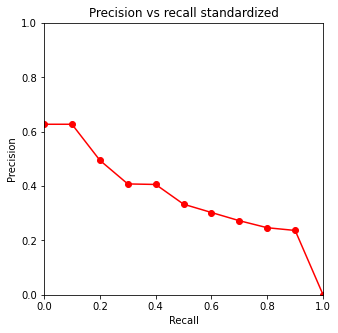

In [45]:
plt.figure(figsize=(5,5))
plt.title("Precision vs recall standardized")
plt.plot(recall, precision, "r-o")
plt.axis([0, 1, 0, 1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

### Parameterized Evaluation

Before, we have explained step by step how the statistics are computed.

The following three cells have the same code as above, but in functions so as to be reused later.

In [46]:
def launch(function, model,dictionary,bow,index,titles):
    """
    God function that allow us to pass independent launch query functions to our get_statistics function. 
    For more info, check Currying (Functional Programming).
    
    """
    def h(query):
        return function(model,dictionary,bow,index,query,titles)
    return h

In [47]:
def get_statistics(launch_query, queries, titles, metadata, judgements):
    """
    General function that allow us to get statistics for all queries given a specific launch query function (model).
    
    Returns
    -------
    It returns all the metrics explained before.
    """
    results = []
    for index in range(len(queries)):
        ranking, _ = launch_query(queries.iloc[index][0])#
        result = get_statistics_query(ranking, index+1, titles, metadata, judgements)
        results.append(result)
    mavp = np.array([query["mavp"] for query in results]).mean()
    precision = np.array([query["precision"] for query in results]).mean(axis=0)
    r_precision = [query["r-precision"] for query in results]
    p_5 = [query["p_5"] for query in results]
    p_10 = [query["p_10"] for query in results]
    recall = np.array([query["recall"] for query in results]).mean(axis=0)
    return {"mavp": mavp, "precision":precision, "r-precision":r_precision, "recall":recall, "p_5": p_5, "p_10": p_10}

In [48]:
def get_statistics_query(ranking, id_query, titles, metadata, judgements):
    """
    Individual function to compute the statistics for a specific query.
    
    Returns
    -------
    It returns all the metrics explained before.
    """
    ranking = [[position[0], position[1]] for position in ranking]
    ranking = pd.DataFrame(ranking, columns=["doc_position", "rel_score"])
    results = ranking
    results["sha"] = results["doc_position"].map(lambda x: titles["id"].iloc[x])
    results["ranking"] = results.index
    results = results.set_index("sha").join(metadata.set_index("sha"))
    results = results.sort_values(by=["ranking"])
    results = results.dropna()
    judgements_parcial = judgements[judgements["query"] == id_query]
    statistics = results.set_index("cord_uid").join(judgements_parcial.set_index("cord_uid"))
    statistics = statistics.dropna()
    r = statistics["binary_score"].sum()
    statistics = statistics[statistics["rel_score"]>0]
    statistics = statistics.sort_values(by=["ranking"])
    statistics = statistics.reset_index()
    statistics["rank"] = statistics.index+1
    statistics["relevant"] = statistics["binary_score"]
    statistics["rel_retrieved"] = statistics["binary_score"].cumsum()
    statistics["precision"] = statistics["rel_retrieved"] / statistics["rank"]
    r = statistics["relevant"].sum()
    if r == 0:
        return {"mavp": 0, "r-precision": 0, "precision": list(np.zeros(11)), "recall":0, "p_10": 0, "p_5": 0}
    statistics["recall"] = statistics["rel_retrieved"] / r
    statistics.drop(["doc_position", "score", "binary_score"], axis=1, inplace=True)
    mavp = (statistics["precision"] * statistics["relevant"]).sum() / r
    r_precision = statistics.iloc[int(r-1)].precision
    precision = statistics["precision"].values
    recall = statistics["recall"].values
    recall_range = np.arange(0,recall.max()+0.1, 0.1)
    precision_recall = [[recall, get_higher_precision(statistics, recall)] for recall in recall_range]
    precision = [precision[1] for precision in precision_recall]
    p_5 = statistics.iloc[4].precision
    p_10 = statistics.iloc[9].precision
    return {"mavp": mavp, "r-precision": r_precision, "precision": precision, "recall":recall_range, "p_10": p_10, "p_5":p_5}

## TFIDF 2.0

Once we have all our structure created: launching queries and computing statistics, we create 4 variations of the TFIDF Model playing with the SMART notation values.

In [49]:
model_tfidf_3 = models.TfidfModel(bow, smartirs="lpu") # Logarithmic term frequency weighting, probabilistic document frequency weighting 
                                                        # and pivoted unique normalization
model_tfidf_2 = models.TfidfModel(bow, smartirs="lfc") # Logarithmic term frequency weighting, idf document frequency weighting 
                                                         # and cosine normalization
model_tfidf_5 = models.TfidfModel(bow, smartirs="ltc") # Logarithmic term frequency weighting, zero-corrected idf document frequency weighting 
                                                         # and cosine normalization
model_tfidf_4 = models.TfidfModel(bow, smartirs="nnn") # Raw term frequency weighting, none document frequency weighting 
                                                         # and none normalization

## Word2Vec

After creating several TFIDF models, we wanted to try the Word2Vec model.

In [50]:
def clean(doc):
    """
    Basic function to clean a document being a document a string with words separated by blank spaces.
    """
    stopset = set(stopwords.words("english"))
    stemmer = PorterStemmer()
    tokens = wordpunct_tokenize(doc)
    clean = [token.lower() for token in tokens if token not in stopset and len(token) > 2 and not token.isnumeric()]
    final = [stemmer.stem(token) for token in clean]
    return " ".join(final)

### Creation

The first thing that we need to do is to create our Word2Vec model. To do that, we need to obtain our dataset (documents and queries).

The following cells create the dataset for our model.

In [51]:
docs = pd.DataFrame((line for line in open("docs.txt")), columns = ["preprocess"])

In [52]:
queries["preprocess"] = queries["query"].apply(lambda x: clean(x))

In [53]:
combined = pd.concat((docs["preprocess"], queries["preprocess"])).sample(frac=1).reset_index(drop=True)

Once we have our dataset, it´s time to create and train our model. 
* **Size**: this is the size of the word embeddings. We chose this value after looking in some papers that suggested using a size between 200-500 for large corpus (as ours).
* **Workers**: if you execute this code, please change this number to maximum number of threads of your computer (cores x 2 if you have hyper threading)

**IMPORTANT** The following cell takes 10 minutes to finish in a computer with a Ryzen 5 3600. Remember this before executing it.

In [54]:
w2v_model = models.Word2Vec([i.split() for i in combined], size = 300, workers=12)

In [55]:
len(w2v_model.wv.vocab) # We check the size of our vocabulary, having more than 300k unique words.

330933

### Saving

After creating our model, we can save it for later use in other applications.

In [56]:
word_vectors = w2v_model.wv
word_vectors.save("word2vec.wordvectors")

In [57]:
w2v_model.save("word2vec.model")

In [58]:
del w2v_model # We delete the model since we only need the word_vectors

### Loading

We load our word_vectors.

In [59]:
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load("word2vec.wordvectors", mmap='r')

### Getting embedding

In [60]:
def get_embedding_w2v(doc_tokens):
    """
    Basic function to obtain the vector representation of a given document (list of tokens).
    
    """
    embeddings = []
    if len(doc_tokens) < 1: # If the length of our document is 0 we return a vector of zeros with size 300 (remember this is the vector size used when creating the model)
        return np.zeros(300)
    else:
        for token in doc_tokens:
            if token in word_vectors.vocab: # if the word is in our vocabulary, we get its vector
                embeddings.append(word_vectors.word_vec(token))
            else:
                embeddings.append(np.random.rand(300)) # if it´s not in our vocabulary a random vector is used
        return np.mean(embeddings, axis = 0) # the vector representation of a document is the mean of its word´s vectors

### Queries embeddings

We compute the vector representations of our queries.

In [61]:
queries["embeddings"] = queries["preprocess"].apply(lambda x: get_embedding_w2v(x.split()))
queries.head()

,query,preprocess,embeddings
1,coronavirus origin,coronaviru origin,"[-0.13622051, 0.18094239, 0.79380023, 0.764305..."
2,coronavirus response to weather changes,coronaviru respons weather chang,"[1.4093331, -0.033406567, 0.49390024, 0.789962..."
3,coronavirus immunity,coronaviru immun,"[-0.01556617, -1.0878538, -0.2560593, -0.69810..."
4,how do people die from the coronavirus,peopl die coronaviru,"[0.723676, -0.0922542, 0.51508594, -0.6484012,..."
5,animal models of COVID-19,anim model covid,"[-0.5845622, 0.33299574, -1.3217245, -0.580382..."


### Documents embeddings

In order to reduce the amount of embeddings to be computed, we filter the documents and we only save the ones that have some query performed on it and appear in metadata.
Then, we compute the embedding for each document, so as to have it precomputed and then, when computing the similarity, just taking this value.

In [62]:
titles = titles.reset_index(drop=True)

In [63]:
docs = titles.join(docs)
docs.head()

,id,title,preprocess
0,0001418189999fea7f7cbe3e82703d71c85a6fe5,Absence of surface expression of feline infect...,absenc surfac express felin infecti periton vi...
1,0003793cf9e709bc2b9d0c8111186f78fb73fc04,Title: Rethinking high-risk groups in COVID-19,titl rethink high risk group covid protect hig...
2,000379d7a7f37a2ccb978862b9f2016bd03259ea,ScienceDirect ScienceDirect Effect of Nanomate...,sciencedirect sciencedirect effect nanomateri ...
3,00039b94e6cb7609ecbddee1755314bcfeb77faa,Plasma inflammatory cytokines and chemokines i...,plasma inflammatori cytokin chemokin sever acu...
4,0003ddc51c4291d742855e9ac56076a3bea33ad7,Journal Pre-proofs The Fire This Time: The Str...,journal pre proof fire time stress racism infl...


In [64]:
# With this filter, we only use documents that appear in both judgements and metadata files, i.e, documents that have queries related.
docs["sha"] = docs["id"]
inCorpus = metadata[metadata["sha"].isin(docs["sha"])]["cord_uid"]
inJudgements = inCorpus[inCorpus.isin(judgements["cord_uid"])]
filtered = metadata.loc[metadata['cord_uid'].isin(inJudgements)]["sha"].values
docs_filtered = docs.loc[docs["id"].isin(filtered)]
docs_filtered.head()

,id,title,preprocess,sha
1,0003793cf9e709bc2b9d0c8111186f78fb73fc04,Title: Rethinking high-risk groups in COVID-19,titl rethink high risk group covid protect hig...,0003793cf9e709bc2b9d0c8111186f78fb73fc04
3,00039b94e6cb7609ecbddee1755314bcfeb77faa,Plasma inflammatory cytokines and chemokines i...,plasma inflammatori cytokin chemokin sever acu...,00039b94e6cb7609ecbddee1755314bcfeb77faa
4,0003ddc51c4291d742855e9ac56076a3bea33ad7,Journal Pre-proofs The Fire This Time: The Str...,journal pre proof fire time stress racism infl...,0003ddc51c4291d742855e9ac56076a3bea33ad7
5,0004456994f6c1d5db7327990386d33c01cff32a,,ackground influenza immunis healthcar worker e...,0004456994f6c1d5db7327990386d33c01cff32a
7,00060fb61742ff60e4e3ba4648c74a34cfe9560d,,outbreak novel coronaviru diseas led current g...,00060fb61742ff60e4e3ba4648c74a34cfe9560d


In [65]:
docs_filtered["embeddings"] = docs_filtered["preprocess"].apply(lambda x: get_embedding_w2v(x.split())) 

<ipython-input-65-6fd6c6ae85e9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs_filtered["embeddings"] = docs_filtered["preprocess"].apply(lambda x: get_embedding_w2v(x.split()))


In [66]:
docs_filtered.head()

,id,title,preprocess,sha,embeddings
1,0003793cf9e709bc2b9d0c8111186f78fb73fc04,Title: Rethinking high-risk groups in COVID-19,titl rethink high risk group covid protect hig...,0003793cf9e709bc2b9d0c8111186f78fb73fc04,"[0.1338663633357819, -0.2122794183152575, -0.1..."
3,00039b94e6cb7609ecbddee1755314bcfeb77faa,Plasma inflammatory cytokines and chemokines i...,plasma inflammatori cytokin chemokin sever acu...,00039b94e6cb7609ecbddee1755314bcfeb77faa,"[0.5001459094016298, -0.33409816613671756, -0...."
4,0003ddc51c4291d742855e9ac56076a3bea33ad7,Journal Pre-proofs The Fire This Time: The Str...,journal pre proof fire time stress racism infl...,0003ddc51c4291d742855e9ac56076a3bea33ad7,"[0.29451135, 0.032466672, -0.34254152, -0.3335..."
5,0004456994f6c1d5db7327990386d33c01cff32a,,ackground influenza immunis healthcar worker e...,0004456994f6c1d5db7327990386d33c01cff32a,"[0.05182570070859275, -0.5597536415046115, 0.0..."
7,00060fb61742ff60e4e3ba4648c74a34cfe9560d,,outbreak novel coronaviru diseas led current g...,00060fb61742ff60e4e3ba4648c74a34cfe9560d,"[0.08706925, -0.3442869, -0.46467376, 0.044986..."


### Launch query in W2V Model

As before with the TFIDF model, we create two functions to launch queries with our W2V model.

We will show you the results for query 2.

In [68]:
from sklearn.metrics.pairwise import cosine_similarity
i = 2

def launch_query_w2v(query_name, queries, docs_filtered, verbose=0):
    """
    General function that allow us to launch queries to our W2V model.
    
    Parameter:
    query_name: the name of the query
    queries: dataframe of the queries
    docs_filtered: dataframe of filtered documents with their vector representation (the one explained before)
    
    Returns:
    
    It returns the ranking.
    
    """
    query_name = query_name
    # We obtain the vector of the query
    query_vector = queries[queries["query"] == query_name]["embeddings"].values[0]
    docs_aux = docs_filtered.copy()
    # We compute the cosine similarity of the query´s vector with the documents vectors
    docs_aux["score"] = docs_aux["embeddings"].apply(
        lambda x: cosine_similarity(np.array(query_vector).reshape(1,-1), np.array(x).reshape(1,-1)).item())
    # We order the docs by this similarity
    docs_aux = docs_aux.sort_values(by="score", ascending=False)
    doc_pos = docs_aux.index.values
    rel_score = docs_aux["score"].values
    ranking = [z for z in zip(doc_pos, rel_score)]
    if verbose:
        print("Query ==> "+query_name)
        for i in range(5):
            score = docs_aux.iloc[i]["score"]
            title = docs_aux.iloc[i]["title"] if docs_aux.iloc[i]["title"]!="" else "No title available"
            print(f"[Score = {score}] "+ title)
    return ranking, "Just to work"

def launch_w2v(function, queries, docs_filtered):
    """
    Again, function that allow us to reuse our code for evaluation.
    """
    def h(query_name):
        return function(query_name, queries, docs_filtered)
    return h

Execution of query 2 with its results. Notice that now the scores are higher.

In [69]:
ranking, _ = launch_query_w2v(queries.iloc[1][0], queries, docs_filtered, verbose=1)

Query ==> coronavirus response to weather changes
[Score = 0.6382498718964247] Journal Pre-proof The most eagerly awaited summer of the Anthropocene: A perspective of SARS- CoV-2 decay and seasonal change
[Score = 0.6366623198065687] Frontiers in climate change-disease research
[Score = 0.6318109618431229] The rise and fall of infectious disease in a warmer world [version 1; referees: 2 approved]
[Score = 0.6306033591859014] Climate Change and Health in Canada
[Score = 0.6229537846403025] Impact of global warming on viral diseases: what is the evidence? This review comes from a themed issue on Pharmaceutical biotechnology Edited


# Results

So, after explaining how we implemented both models, it´s turn to evaluate them.

We will consider the metrics explained before: precision, recall, mean average precision, P@5, P@10 and R-Precision.

The following cell performs all the evaluation:
* We print the P@5, P@10 and MAVP of each single document.
* We plot a graph comparing the precision and recall of all the models tested.
* We plot a graph comparing the difference of the R-precision of the best two models for each single query. If the values are positive mean that R-precision of model A was greater than model´s B R-Precision. Negative values mean that that R-precision of model B was greater than model´s A R-Precision

The evaluation procedure was created following the indications in (Baeza and Ribeiro, 2011).

###################################################################################
Evaluating performance of our models...
-------------------------------------------------------------------------------------
Evaluating TFIDF (nfc): raw term frequency weighing, idf document frequency weighting, cosine normalization
Computing statistics...
Statistics computed...
Mean Average Precision of this model ==> 0.4982978899333098
Mean P@5 of this model ==> 0.572
Mean P@10 of this model ==> 0.592
-------------------------------------------------------------------------------------
Evaluating TFIDF (lfc): logarithmic term frequency weighing, idf document frequency weighting, cosine normalization
Computing statistics...
Statistics computed...
Mean Average Precision of this model ==> 0.4982978899333098
Mean P@5 of this model ==> 0.572
Mean P@10 of this model ==> 0.592
-------------------------------------------------------------------------------------
Evaluating TFIDF (lpu): logarithmic term frequ

C:\Users\César\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


Statistics computed...
Mean Average Precision of this model ==> 0.5087887531431804
Mean P@5 of this model ==> 0.5479999999999999
Mean P@10 of this model ==> 0.574
-------------------------------------------------------------------------------------
Evaluating TFIDF (nnn): raw term frequency weighing, none document frequency weighting, none normalization
Computing statistics...
Statistics computed...
Mean Average Precision of this model ==> 0.46953154581265527
Mean P@5 of this model ==> 0.5519999999999999
Mean P@10 of this model ==> 0.536
-------------------------------------------------------------------------------------
Evaluating TFIDF (ltc): logarithmic term frequency weighing, zero-corrected idf document frequency weighting, cosine normalization
Computing statistics...
Statistics computed...
Mean Average Precision of this model ==> 0.49829782771365694
Mean P@5 of this model ==> 0.572
Mean P@10 of this model ==> 0.592
----------------------------------------------------------------

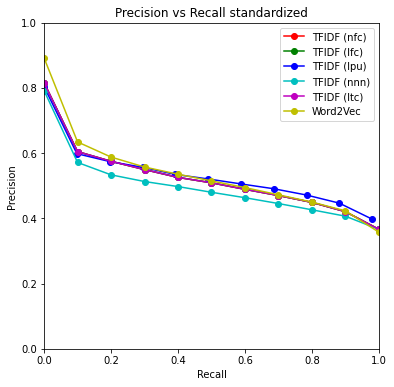

-------------------------------------------------------------------------------------
Comparing our models: W2V vs TFIDF (lpu)


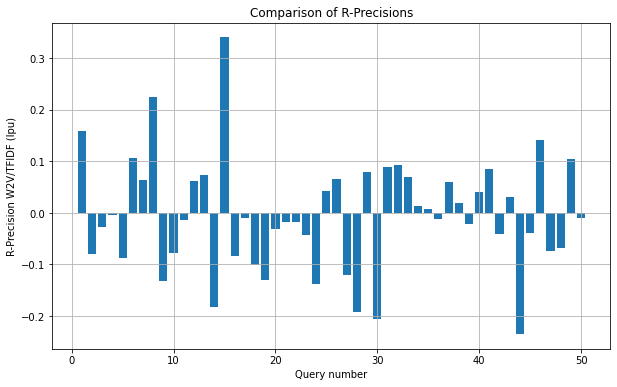

-------------------------------------------------------------------------------------
Evalution finished.
###################################################################################


In [343]:
recall = np.arange(0,1.1, 0.1)
modelos_tfidf = [{"name":"TFIDF (nfc)", "term": "raw", "document": "idf", "normalization": "cosine", "model": model_tfidf, "color": "r"},
          {"name":"TFIDF (lfc)", "term": "logarithmic", "document": "idf", "normalization": "cosine", 
           "model": model_tfidf_2, "color": "g"},
           {"name":"TFIDF (lpu)", "term": "logarithmic", "document": "probabilistic", "normalization": "pivoted unique", 
           "model": model_tfidf_3, "color": "b"},
           {"name":"TFIDF (nnn)", "term": "raw", "document": "none", "normalization": "none", 
           "model": model_tfidf_4, "color": "c"},
           {"name":"TFIDF (ltc)", "term": "logarithmic", "document": "zero-corrected idf", "normalization": "cosine", 
           "model": model_tfidf_5, "color": "m"}
         ]

modelos_w2v = [{"name": "Word2Vec", "algorithm": "Continuous Bag of Words", "vector": 300, 
                "window": "5 (default)", "negative": "5 (default)", "epochs": "5 (default)", "color":"y"}
              ]
r_precisions = []
precisions_5 = []
precisions_10 = []

print("###################################################################################")
print("Evaluating performance of our models...")
plt.figure(figsize=(6,6))
plt.title("Precision vs Recall standardized")
plt.axis([0, 1, 0, 1])
plt.xlabel("Recall")
plt.ylabel("Precision")

for model in modelos_tfidf:
    name = model["name"]
    term = model["term"]
    document = model["document"]
    normalization = model["normalization"]
    color = model["color"]
    print("-------------------------------------------------------------------------------------")
    print(f"Evaluating {name}: {term} term frequency weighing, {document} document frequency weighting, {normalization} normalization")
    print("Computing statistics...")
    data_tfidf = get_statistics(launch(launch_query_tfidf,model["model"], dictionary, bow, similarities, titles.copy()), queries.copy(), titles.copy(), metadata.copy(), judgements.copy())
    print("Statistics computed...")
    precision_tfidf = data_tfidf["precision"]
    recall = data_tfidf["recall"]
    mavp_tfidf = data_tfidf["mavp"]
    precisions_5.append(np.array(data_tfidf["p_5"]).mean())
    precisions_10.append(np.array(data_tfidf["p_10"]).mean())
    r_precisions.append(data_tfidf["r-precision"])
    print(f"Mean Average Precision of this model ==> {mavp_tfidf}")
    p_5 = np.array(data_tfidf["p_5"]).mean()
    p_10 = np.array(data_tfidf["p_10"]).mean()
    print(f"Mean P@5 of this model ==> {p_5}")
    print(f"Mean P@10 of this model ==> {p_10}")

    plt.plot(recall, precision_tfidf, f"{color}-o", label=name)

for model in modelos_w2v:
    name = model["name"]
    vector = model["vector"]
    window = model["window"]
    negative = model["negative"]
    algorithm = model["algorithm"]
    epochs = model["epochs"]
    color = model["color"]
    print("-------------------------------------------------------------------------------------")
    print(f"Evaluating {name}: \n\tTraining algorithm = {algorithm}\n\tVector size = {vector}\n\tDistance predicted and current word = {window}\n\tNegative sampling = {negative}\n\tEpochs = {epochs}")
    print("Computing statistics...")
    data_w2v = get_statistics(launch_w2v(launch_query_w2v, queries.copy(), docs_filtered.copy()), queries.copy(), titles.copy(), metadata.copy(), judgements.copy())
    print("Statistics computed...")
    precision_w2v = data_w2v["precision"]
    recall = data_w2v["recall"]
    mavp_w2v = data_w2v["mavp"]
    r_precisions.append(data_w2v["r-precision"])
    precisions_5.append(np.array(data_w2v["p_5"]).mean())
    precisions_10.append(np.array(data_w2v["p_10"]).mean())
    print(f"Mean Average Precision of this model ==> {mavp_w2v}")
    p_5 = np.array(data_w2v["p_5"]).mean()
    p_10 = np.array(data_w2v["p_10"]).mean()
    print(f"Mean P@5 of this model ==> {p_5}")
    print(f"Mean P@10 of this model ==> {p_10}")

    plt.plot(recall, precision_w2v, f"{color}-o", label=name)

plt.legend()
plt.show()
print("-------------------------------------------------------------------------------------")
print("Comparing our models: W2V vs TFIDF (lpu)")
r_precision = np.array(r_precisions[5]) - np.array(r_precisions[2])
# the histogram of the data
plt.figure(figsize=(10,6))
plt.bar(np.arange(1,51,1),r_precision)
plt.xlabel('Query number')
plt.ylabel('R-Precision W2V/TFIDF (lpu)')
plt.title('Comparison of R-Precisions')
plt.grid(True)
plt.show()
print("-------------------------------------------------------------------------------------")
print("Evalution finished.")
print("###################################################################################")

# Conclusions

